<a href="https://colab.research.google.com/github/Yi-Wei-Lin/Tibame_ML_20210602/blob/main/Cabbage_predict(future_day).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Recurrent Neural Network



# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Importing the training set
dataset_train = pd.read_excel('Cabbage_train.xlsx')
# dataset_train = dataset_train.dropna().loc[dataset_train.dropna()["Market"]=="台北一"]
training_set = dataset_train.iloc[:, 6:7].values



# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
time_step = 60
data_len = len(training_set_scaled)
# for i in range(time_step, data_len):
#     X_train.append(training_set_scaled[i-time_step : i, 0])
#     y_train.append(training_set_scaled[i, 0])

# 加 future day
future_day = 5
for i in range(data_len - time_step - future_day):
    X_train.append(training_set_scaled[i : i + time_step, 0])
    y_train.append(training_set_scaled[i + time_step: i + time_step + future_day, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [2]:
# X_train, X_test, y_train, y_test = train_test_split(X_train, test_size=0.1)
dataset_train

,Date,Market,Product,Up_price,Mid_price,Low_price,Avg_price,Volume,Month,Week_day,Year,Rest_day
0,2000-01-02,台北一,LA1 甘藍 初秋,11.0,8.0,5.0,8.9,192029,1,7,2000,0
1,2000-01-03,台北一,LA1 甘藍 初秋,9.0,7.0,4.0,7.2,174270,1,1,2000,0
2,2000-01-04,台北一,LA1 甘藍 初秋,8.0,6.0,3.0,6.7,125426,1,2,2000,0
3,2000-01-05,台北一,LA1 甘藍 初秋,10.0,7.0,4.0,7.1,119318,1,3,2000,0
4,2000-01-06,台北一,LA1 甘藍 初秋,9.0,7.0,5.0,6.8,118178,1,4,2000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362,2020-12-26,台北一,LA1 甘藍 初秋,31.1,25.3,14.9,24.4,163218,12,6,2020,0
6363,2020-12-27,台北一,LA1 甘藍 初秋,32.3,24.8,16.7,24.7,154663,12,7,2020,0
6364,2020-12-29,台北一,LA1 甘藍 初秋,32.0,26.2,15.3,25.2,171005,12,2,2020,0
6365,2020-12-30,台北一,LA1 甘藍 初秋,31.4,24.8,15.6,24.3,164606,12,3,2020,0


In [3]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 5))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
callback = [
    EarlyStopping(patience=20, restore_best_weights=True),
    ModelCheckpoint("regressor.h5", save_best_only=True)
]
regressor.fit(X_train, y_train, epochs = 200, batch_size = 32, validation_split=0.1, callbacks=callback)

Epoch 1/200
178/178 [==============================] - 28s 23ms/step - loss: 0.0199 - val_loss: 0.0056
Epoch 2/200
178/178 [==============================] - 2s 13ms/step - loss: 0.0073 - val_loss: 0.0049
Epoch 3/200
178/178 [==============================] - 2s 13ms/step - loss: 0.0061 - val_loss: 0.0045
Epoch 4/200
178/178 [==============================] - 2s 13ms/step - loss: 0.0055 - val_loss: 0.0044
Epoch 5/200
178/178 [==============================] - 2s 13ms/step - loss: 0.0054 - val_loss: 0.0041
Epoch 6/200
178/178 [==============================] - 2s 13ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 7/200
178/178 [==============================] - 2s 13ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 8/200
178/178 [==============================] - 2s 13ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 9/200
178/178 [==============================] - 2s 13ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 10/200
178/178 [==============================] - 2s 12ms/step - loss: 0.00

In [4]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2017
dataset_test = pd.read_excel('Cabbage_test.xlsx')
real_stock_price = dataset_test.iloc[:, 6:7].values

# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Avg_price'], dataset_test['Avg_price']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_step :].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
test_data_len = len(inputs)
# for i in range(time_step, test_data_len):
#     X_test.append(inputs[i-time_step : i, 0])

# future_day
for i in range(test_data_len - time_step - future_day):
    X_test.append(inputs[i : i + time_step, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [7]:
predicted_stock_price

array([[27.197569 , 26.781557 , 26.937063 , 26.736258 , 26.798603 ],
       [27.326422 , 26.961845 , 27.145489 , 26.955702 , 27.026749 ],
       [26.180677 , 26.00891  , 26.245396 , 26.070581 , 26.118479 ],
       [28.011053 , 27.603231 , 27.775953 , 27.585512 , 27.660719 ],
       [25.206945 , 25.216208 , 25.499958 , 25.339611 , 25.36702  ],
       [26.962748 , 26.687723 , 26.88623  , 26.703613 , 26.7571   ],
       [28.452904 , 28.017756 , 28.182076 , 27.990133 , 28.070498 ],
       [28.883745 , 28.465748 , 28.643494 , 28.45414  , 28.537714 ],
       [29.118317 , 28.728615 , 28.914766 , 28.723495 , 28.799364 ],
       [31.178219 , 30.57605  , 30.703587 , 30.492609 , 30.583006 ],
       [32.585182 , 31.908812 , 32.02192  , 31.800726 , 31.896465 ],
       [36.573654 , 35.520645 , 35.527164 , 35.27411  , 35.38297  ],
       [34.261833 , 33.71254  , 33.88425  , 33.673916 , 33.77701  ],
       [34.28419  , 33.76843  , 33.926636 , 33.705643 , 33.775314 ],
       [29.841507 , 29.883316 , 30

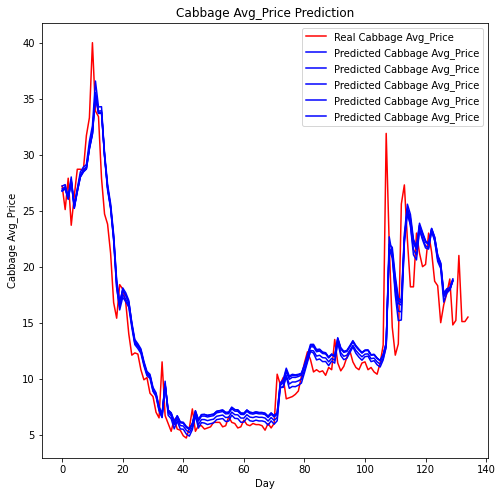

In [6]:
# Visualising the results
plt.figure(figsize=(8,8))
plt.plot(real_stock_price, color = 'red', label = 'Real Cabbage Avg_Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Cabbage Avg_Price')
plt.title('Cabbage Avg_Price Prediction')
plt.xlabel('Day')
plt.ylabel('Cabbage Avg_Price')
plt.legend()
plt.show()